In [1]:
from sklearn.datasets import make_circles, make_moons
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from cvxopt import matrix
from cvxopt import solvers
from numpy import linalg as LA

## Load nonlinear dataset

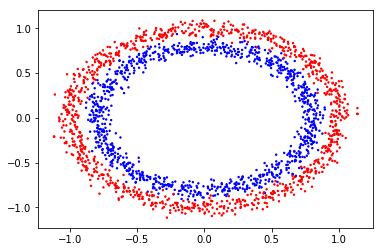

In [2]:
X, y = make_circles(n_samples=2000, noise=0.05)
colors = ['red','blue']
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(colors), s=2)
y[y == 0] = -1
seed = 1

## Fourier transformation of kernel functions

In [3]:
def gaussian_fourier(w, D):
    return (2*np.pi)**(-D/2) * np.exp(-LA.norm(w)/2)

## MCMC sampling algorithm

In [4]:
def metropolis_hastings(p, dim, iter=1000):
    x = np.zeros(dim)
    samples = np.zeros((iter, dim))

    for i in range(iter):
        x_next = x + np.random.multivariate_normal(np.zeros(dim), np.eye(dim))
        if np.random.rand() < p(x_next, dim) / p(x, dim):
            x = x_next
        samples[i] = x

    return samples

## Compute feature map

In [5]:
D = 2000
d = 2
max_iter = 1000
X_train_original, X_test_original, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

s = metropolis_hastings(gaussian_fourier, dim=d, iter=max_iter)
w = s[np.random.randint(low=10, high=max_iter, size=D)]
b = np.random.uniform(low=0, high=2*np.pi, size=D)
X_train = np.zeros((X_train_original.shape[0], D))
X_test = np.zeros((X_test_original.shape[0], D))

for i in range(X_train_original.shape[0]):
    for j in range(D):
        X_train[i, j] = np.cos(np.dot(w[j], X_train_original[i]) + b[j]) * np.sqrt(2/D)

for i in range(X_test_original.shape[0]):
    for j in range(D):
        X_test[i, j] = np.cos(np.dot(w[j], X_test_original[i]) + b[j]) * np.sqrt(2/D)

## Use Quadratic Programming Solver to solve a linear kernel SVM with computed feature map

In [6]:
m,n = X_train.shape
y_train = y_train.reshape(-1,1) * 1.
K = np.dot(X_train, X_train.T)
H = np.outer(y_train, y_train) * K
H.shape

(1600, 1600)

In [7]:
C = 10
P = matrix(H)
q = matrix(-np.ones(m))
G = matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
h = matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
A = matrix(y_train, (1, m))
b = matrix(0.)

#Run solver
sol = solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

alphas = alphas.reshape(alphas.shape[0])

sup_vec_idx = np.argwhere(alphas > 1e-4)
sup_vec_idx = sup_vec_idx.reshape(sup_vec_idx.shape[0])
X_sup_vec = X_train[sup_vec_idx]
y_sup_vec = y_train[sup_vec_idx]
alphas_sup_vec = alphas[sup_vec_idx]

     pcost       dcost       gap    pres   dres
 0:  1.3298e+03 -9.3264e+04  2e+05  6e-01  2e-14
 1:  3.3705e+03 -1.7627e+04  2e+04  1e-04  2e-14
 2:  1.8914e+02 -3.9904e+03  4e+03  2e-05  2e-14
 3: -3.3114e+02 -2.7134e+03  2e+03  8e-06  2e-14
 4: -6.1611e+02 -2.0139e+03  1e+03  5e-06  2e-14
 5: -8.0430e+02 -1.6137e+03  8e+02  2e-06  2e-14
 6: -8.9661e+02 -1.4543e+03  6e+02  1e-06  2e-14
 7: -9.7593e+02 -1.3046e+03  3e+02  7e-07  2e-14
 8: -1.0321e+03 -1.2030e+03  2e+02  3e-07  2e-14
 9: -1.0665e+03 -1.1417e+03  8e+01  4e-08  3e-14
10: -1.0890e+03 -1.1096e+03  2e+01  3e-09  3e-14
11: -1.0949e+03 -1.1023e+03  7e+00  6e-10  2e-14
12: -1.0982e+03 -1.0985e+03  3e-01  2e-11  3e-14
13: -1.0984e+03 -1.0984e+03  6e-03  4e-13  3e-14
14: -1.0984e+03 -1.0984e+03  9e-05  2e-14  3e-14
Optimal solution found.


## Computer weight w and bias term b

In [8]:
w = np.zeros(D)
for i in range(alphas_sup_vec.shape[0]):
    w += alphas_sup_vec[i] * y_sup_vec[i] * X_sup_vec[i]

In [9]:
b = - (np.max(np.dot(X_train[np.where(y_train == -1)[0]], w)) + np.min(np.dot(X_train[np.where(y_train == 1)[0]], w))) / 2

## Test set accuracy

In [10]:
np.sum((np.sign(np.dot(X_test, w) + b) == y_test).astype("int")) / X_test.shape[0]

0.9725

## Visualizing support vectors

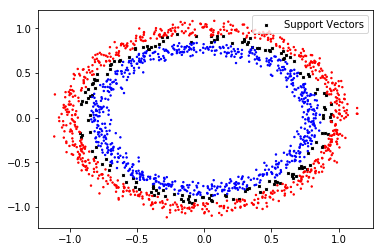

In [11]:
X_sup_vec_original = X_train_original[sup_vec_idx]
X_non_sup_vec = X_train_original[~np.isin(np.arange(len(X_train_original)), sup_vec_idx)]
y_non_sup_vec = y_train[~np.isin(np.arange(len(y_train)), sup_vec_idx)]
y_non_sup_vec = y_non_sup_vec.reshape(y_non_sup_vec.shape[0])
fig, ax = plt.subplots()
colors = ['red','blue']
ax.scatter(X_sup_vec_original[:, 0], X_sup_vec_original[:, 1], c="black", s=6, marker='x', label="Support Vectors")
ax.scatter(X_non_sup_vec[:, 0], X_non_sup_vec[:, 1], c=y_non_sup_vec, cmap=matplotlib.colors.ListedColormap(colors), s=2)
ax.legend(loc="upper right")
plt.show()